# NYC Apartment Search

## Setup

In [1]:
# Standard library imports
import json
import os
import io
import glob
import warnings
from datetime import datetime

# File and path handling
import pathlib

# HTTP and URL handling
import urllib.parse
import requests

# Data handling and analysis
import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas.tools import sjoin

# Database and SQL handling
import psycopg2
import sqlalchemy as db
from sqlalchemy import create_engine, Column, Integer, String, Float, Date, text
from sqlalchemy.orm import declarative_base, sessionmaker

# Geometry and spatial analysis
import shapely
from shapely.geometry import Point, Polygon
from shapely import wkt
import geoalchemy2 as gdb
from geoalchemy2 import Geometry

# Visualization and plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import contextily as ctx
import seaborn as sns
from PIL import Image

# IPython and widgets
from IPython.display import Image as IPImage, display, HTML
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
from ipywidgets.embed import embed_minimal_html

# Warnings configuration
warnings.filterwarnings('ignore')

In [2]:
# Where data files will be read from/written to - this should already exist
DATA_DIR = pathlib.Path("data")
ZIPCODE_DATA_FILE = DATA_DIR / "zipcodes" / "ZIP_CODE_040114.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

# Download NYC Data
url_311 = 'https://data.cityofnewyork.us/resource/erm2-nwe9.csv'
url_trees = 'https://data.cityofnewyork.us/resource/5rq2-4hqu.csv'
NYC_DATA_APP_TOKEN = "UYsSh8MfAPVog5LPL1G3ySktk"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

# create schema.sql file
DB_SCHEMA_FILE = "schema.sql"
# directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("queries")

In [3]:
# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()

## Part 1: Data Preprocessing

### 1. Export Data

In [4]:
def download_nyc_geojson_data(url, app_token, filename, date_field, 
                              start_date, end_date, date_format="%Y-%m-%dT%H:%M:%S", limit=10000):
    """
    Downloads NYC GeoJSON data within a specified date range and writes it to a file.

    This function fetches data from a specified URL using API requests, filtering the data based on a date range. It then writes the data into a file in batches, handling pagination through the 'offset' parameter.

    Parameters:
    - url (str): The URL endpoint for the API from which data is to be fetched.
    - app_token (str): Application token for API access.
    - filename (str): Name of the file where the downloaded data will be saved.
    - date_field (str): The field in the data used to filter by date.
    - start_date (datetime): The start date for the data query.
    - end_date (datetime): The end date for the data query.
    - date_format (str, optional): The format in which dates are represented. Defaults to "%Y-%m-%dT%H:%M:%S".
    - limit (int, optional): The maximum number of records to fetch per request. Defaults to 10000.

    Returns:
    None. The function writes the data to the specified file and prints a message if any request fails.

    The function iterates over batches of data until all records within the specified date range are retrieved and saved to the file. It ensures that the column headers are written only once and handles any HTTP errors encountered during the requests.
    """
    offset = 0
    start_date_str = start_date.strftime(date_format)
    end_date_str = end_date.strftime(date_format)
    date_query = f"$where={date_field} between '{start_date_str}' and '{end_date_str}'"
    
    # set up as the first batch
    first_batch = True  
    while True:
        full_url = f"{url}?$$app_token={app_token}&{date_query}&$limit={limit}&$offset={offset}"
        response = requests.get(full_url)

        if response.status_code == 200:
            data = response.text
            # count the records have been exported
            records_retrieved = data.count('\n') 
            
            # To check if it is the first batch and whether have value
            if first_batch and records_retrieved > 0: 
                # only keep column name in the first batch
                with open(filename, 'w') as file:
                    file.write(data)
                first_batch = False
            elif records_retrieved > 1:  # 
                with open(filename, 'a') as file:
                    # slip the column name
                    file.write(data.split('\n', 1)[1])  
            
            # to check if the data have been exported or not
            if records_retrieved < limit + 1: 
                break
            offset += limit
        else:
            print(f"Failed to download data at offset {offset}: Status code {response.status_code}")
            break

#### 1.1 Download tree 2015 data

In [5]:
# export tree data
download_nyc_geojson_data(
    url=url_trees,
    app_token=NYC_DATA_APP_TOKEN,  
    filename="data/tree_data.csv",
    date_field="created_at",  
    start_date=datetime(2015, 1, 1),
    end_date=datetime(2015, 12, 31),
    date_format="%m/%d/%Y",  
    limit=250000
)

**<span style="color: red;">Test the function 1</span>**

Test for File Existence: This test will check if the tree_data.csv file is created in the specified directory after executing the function.

In [6]:
assert os.path.isfile("data/tree_data.csv"), "File tree_data.csv does not exist"

#### 1.2 Download complaint 311 data by year

The 311 complaint data set is potentially too extensive to import and preprocess directly in the notebook. To manage this, we've opted to process the data on a yearly basis. This involves writing each year's data to a separate CSV file, which we then read individually for preprocessing. Our chosen timeframe extends from January 1, 2015, at 00:00:00 to September 30, 2023, at 23:59:59. This selection aligns with the 2015 tree data, which begins in 2015. Furthermore, we chose the end date to coincide with our query question, which concludes on September 30, 2023.

In [7]:
# Download 311 data from 2015.1.1-2023.9.30 (which is the last date refers in the query)
# Create a new folder to save 311 data by year since the data size is too large
subfolder_name = "311_data"
subfolder_path = os.path.join("data", subfolder_name)
if not os.path.exists(subfolder_path):
    os.makedirs(subfolder_path)

In [8]:
# 311 data for 2015
download_nyc_geojson_data(
    url_311,
    app_token=NYC_DATA_APP_TOKEN,
    filename="data/311_data/311_data_2015.csv",
    date_field="created_date",
    start_date=datetime(2015, 1, 1, 0, 0, 0),
    end_date=datetime(2015, 12, 31, 23, 59, 59),
    date_format="%Y-%m-%dT%H:%M:%S",
    limit=250000
)

In [9]:
# 311 data for 2016
download_nyc_geojson_data(
    url_311,
    app_token=NYC_DATA_APP_TOKEN,
    filename="data/311_data/311_data_2016.csv",
    date_field="created_date",
    start_date=datetime(2016, 1, 1, 0, 0, 0),
    end_date=datetime(2016, 12, 31, 23, 59, 59),
    date_format="%Y-%m-%dT%H:%M:%S",
    limit=250000
)

In [10]:
# 311 data for 2017
download_nyc_geojson_data(
    url_311,
    app_token=NYC_DATA_APP_TOKEN,
    filename="data/311_data/311_data_2017.csv",
    date_field="created_date",
    start_date=datetime(2017, 1, 1, 0, 0, 0),
    end_date=datetime(2017, 12, 31, 23, 59, 59),
    date_format="%Y-%m-%dT%H:%M:%S",
    limit=250000
)

In [11]:
# 311 data for 2018
download_nyc_geojson_data(
    url_311,
    app_token=NYC_DATA_APP_TOKEN,
    filename="data/311_data/311_data_2018.csv",
    date_field="created_date",
    start_date=datetime(2018, 1, 1, 0, 0, 0),
    end_date=datetime(2018, 12, 31, 23, 59, 59),
    date_format="%Y-%m-%dT%H:%M:%S",
    limit=250000
)

In [12]:
# 311 data for 2019
download_nyc_geojson_data(
    url_311,
    app_token=NYC_DATA_APP_TOKEN,
    filename="data/311_data/311_data_2019.csv",
    date_field="created_date",
    start_date=datetime(2019, 1, 1, 0, 0, 0),
    end_date=datetime(2019, 12, 31, 23, 59, 59),
    date_format="%Y-%m-%dT%H:%M:%S",
    limit=250000
)

In [13]:
# 311 data for 2020
download_nyc_geojson_data(
    url_311,
    app_token=NYC_DATA_APP_TOKEN,
    filename="data/311_data/311_data_2020.csv",
    date_field="created_date",
    start_date=datetime(2020, 1, 1, 0, 0, 0),
    end_date=datetime(2020, 12, 31, 23, 59, 59),
    date_format="%Y-%m-%dT%H:%M:%S",
    limit=250000
)

In [14]:
# 311 data for 2021
download_nyc_geojson_data(
    url_311,
    app_token=NYC_DATA_APP_TOKEN,
    filename="data/311_data/311_data_2021.csv",
    date_field="created_date",
    start_date=datetime(2021, 1, 1, 0, 0, 0),
    end_date=datetime(2021, 12, 31, 23, 59, 59),
    date_format="%Y-%m-%dT%H:%M:%S",
    limit=250000
)

In [15]:
# 311 data for 2022
download_nyc_geojson_data(
    url_311,
    app_token=NYC_DATA_APP_TOKEN,
    filename="data/311_data/311_data_2022.csv",
    date_field="created_date",
    start_date=datetime(2022, 1, 1, 0, 0, 0),
    end_date=datetime(2022, 12, 31, 23, 59, 59),
    date_format="%Y-%m-%dT%H:%M:%S",
    limit=250000
)

In [16]:
# 311 data for 2023
download_nyc_geojson_data(
    url_311,
    app_token=NYC_DATA_APP_TOKEN,
    filename="data/311_data/311_data_2023.csv",
    date_field="created_date",
    start_date=datetime(2023, 1, 1, 0, 0, 0),
    end_date=datetime(2023, 9, 30, 23, 59, 59),
    date_format="%Y-%m-%dT%H:%M:%S",
    limit=250000
)

**<span style="color: red;">Test the function 2</span>**

Content: Ensure that the file is not only created but also contains data. This test checks if the file is non-empty.And also for the 311 complaint data the file

In [17]:
directory="data/311_data"
file_count = len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])
assert file_count == 9, f"Expected 9 files, found {file_count}"

### 2. Cleaning & filtering

all the column name is lower case and rename it to the tree(standard), and all zip code need be integer.

|zip        | rent      | complaint   | tree      |description           |
|-----------|-----------|-------------|-----------|----------------------|
|ZIPCODE    |RegionName |incident_zip |zipcode    |five digit postal code|
|           |           |longitude    |longitude  |longitude coordinates |
|           |           |latitude     |latitude   |latitude coordinates  |
|geometry   |           |geometry     |geometry   |geometry  |

**SRID  Normalization: choose 3857 for data visualization**

The SRID (Spatial Reference System Identifier) 3857 is chosen primarily for its compatibility with web mapping and visualization tools, which is excellent for display purposes,. It is the standard coordinate system used by many online mapping services, such as Google Maps and OpenStreetMap. This compatibility facilitates straightforward integration of geospatial data with these platforms, enabling the wide dissemination and easy visualization of geospatial information on the web.

#### 2.1 Clean Zip Code

|zip        |description           |
|-----------|----------------------|
|ZIPCODE    |five digit postal code|
|geometry   |geometry  |

In [4]:
def load_and_clean_zipcodes(zipcode_datafile):
    """
    Loads and cleans a zipcode dataset from a specified file.

    This function performs the following operations on the dataset:
    1. Loads the data from the given file path.
    2. Retains only essential columns, specifically 'ZIPCODE' and 'geometry'.
    3. Removes duplicate entries and invalid data points, ensuring that ZIPCODEs are unique and valid.
    4. Deletes rows with missing ZIPCODE or geometry data.
    5. Converts ZIPCODE from a floating-point to an integer format, retaining only 5-digit ZIPCODEs.
    6. Renames the 'ZIPCODE' column to 'zipcode' and converts all column names to lowercase.
    7. Normalizes the Spatial Reference Identifiers (SRID) of any geometry to the target SRID 'EPSG:3857'.

    Parameters:
    - zipcode_datafile (str): The file path where the zipcode data file is stored.

    Returns:
    - DataFrame: A cleaned and processed pandas DataFrame containing the zipcode data.
    """
    # Load Data
    zip_df = gpd.read_file(zipcode_datafile)

    # 1. Remove unnecessary columns
    keep_columns = ['ZIPCODE', 'geometry']
    clean_zip = zip_df[keep_columns]

    # 2. Remove invalid data points
    # 2.1 Confirm unique_key
    clean_zip = clean_zip.drop_duplicates(subset='ZIPCODE')
    clean_zip = clean_zip[clean_zip['ZIPCODE'].notna() & clean_zip['ZIPCODE'].apply(lambda x: str(x).isdigit())]

    # Define the condition for rows to be removed: remove the data which does not have all location-related data below
    condition = clean_zip['ZIPCODE'].isna() | clean_zip['geometry'].isna()
    # Remove rows based on the condition
    clean_zip = clean_zip[~condition]
    # remove the rows that all cell is nan
    clean_zip = clean_zip.dropna()
    # The zipcode convert it from float to intger
    clean_zip['ZIPCODE'] = clean_zip['ZIPCODE'].astype(int)
    # check if it lasts with 5 digits
    clean_zip = clean_zip[clean_zip['ZIPCODE'].apply(lambda x: str(x).isdigit() and len(str(x)) == 5)]


    # 3. Normalize column names & column types
    # 3.1 Rename the column
    clean_zip.rename(columns={'ZIPCODE': 'zipcode'}, inplace=True)
    # Change all name to lowercase
    clean_zip.columns = [col.lower() for col in clean_zip.columns]

    # 3.2 Reframe the column value type

    # 4. Normalize the Spatial Reference Identifiers (SRID) of any geometry.
    target_srid = "EPSG:3857"
    clean_zip = clean_zip.to_crs(target_srid)

    return clean_zip

**<span style="color: red;">Test the function 3</span>**

To check if the zipcode in zipcode file is already distinct or not, that could help us to extract the zipcode from NYC for the follow dataframe

In [5]:
geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
zip_list_nyc=geodf_zipcode_data['zipcode'].unique()
assert len(zip_list_nyc)==geodf_zipcode_data.shape[0]

#### 2.2 311 Complaint Data Clean

| Field Name     | Description |
|----------------|-------------|
| Unique Key     | Unique identifier of a Service Request (SR) in the open data set. |
| Incident Zip   | Incident location zip code, provided by geo validation. |
| Created Date   | Date SR was created. |
| Complaint Type | This is the first level of a hierarchy identifying the topic of the incident or condition. Complaint Type may have a corresponding Descriptor (below) or may stand alone. |
| longitude      | Geo based Long of the incident location. |
| latitude       | Geo based Lat of the incident location. |

In [6]:
def download_and_clean_311_data(path):
    """
    This function downloads and cleans 311 complaint data.

    The function performs the following steps:
    1. Loads data from the specified CSV file path.
    2. Keeps only essential columns: 'unique_key', 'incident_zip', 'created_date', 'complaint_type', 'longitude', and 'latitude'.
    3. Removes duplicate records and ensures all 'unique_key' values are non-null and numeric.
    4. Excludes rows without complete location-related data (zip code, longitude, latitude).
    5. Ensures latitude and longitude values are within valid ranges.
    6. Removes rows with all NaN values.
    7. Converts 'incident_zip' from float to integer and checks for 5-digit validity.
    8. Filters zip codes to include only those within a predefined list of NYC zip codes.
    9. Renames columns for consistency and converts all column names to lowercase.
    10. Reformats the 'created_date' column to 'YYYY-MM-DD' format.
    11. Transforms the DataFrame into a GeoDataFrame, normalizing spatial reference identifiers (SRID) to EPSG:4326 and then converting to EPSG:3857.

    Parameters:
    path (str): The file path of the 311 data CSV file, e.g., "data/311_data.csv".

    Returns:
    gpd.GeoDataFrame: A cleaned and geospatially normalized DataFrame containing 311 complaint data.
    """
    # Load Data
    complaint_df = pd.read_csv(path)

    # 1. Remove unnecessary columns
    keep_columns = ['unique_key', 'incident_zip', 'created_date', 'complaint_type', 'longitude', 'latitude']
    clean_311 = complaint_df[keep_columns]

    # 2. Remove invalid data points
    # 2.1 Confirm unique_key
    clean_311 = clean_311.drop_duplicates(subset='unique_key')
    clean_311 = clean_311[clean_311['unique_key'].notna() & clean_311['unique_key'].apply(lambda x: str(x).isdigit())]

    # Define the condition for rows to be removed: remove the data which does not have all location-related data below
    condition = clean_311['incident_zip'].isna() | clean_311['longitude'].isna() | clean_311['latitude'].isna()
    # Remove rows based on the condition
    clean_311 = clean_311[~condition]
    # only keep the records with vaild latitude and longitude
    clean_311= clean_311[(clean_311['latitude'].between(-90, 90)) & (clean_311['longitude'].between(-180, 180))]
    # remove the rows that all cell is nan
    clean_311=clean_311.dropna()
    # The zipcode convert it from float to intger
    clean_311['incident_zip'] = clean_311['incident_zip'].astype(int)
    # check if it lasts with 5 digits
    clean_311 = clean_311[clean_311['incident_zip'].apply(lambda x: str(x).isdigit() and len(str(x)) == 5)]
    # only keep the zipcode that in zip_list_nyc
    clean_311 = clean_311[clean_311['incident_zip'].isin(zip_list_nyc)]

    # 3. Normalize column names & column types
    # 3.1 Rename the column
    clean_311.rename(columns={'incident_zip': 'zipcode','created_date':'date','unique_key': 'complaint_id'}, inplace=True)
    # Change all name to lowercase
    clean_311.columns = [col.lower() for col in clean_311.columns]

    # 3.2 Reframe the column value type
    # Create a new column that makes created date only keep year-month-day 2023-11-12
    clean_311['date'] = pd.to_datetime(clean_311['date'])
    clean_311['date'] = clean_311['date'].dt.strftime('%Y-%m-%d')

    # 4. Normalize the Spatial Reference Identifiers (SRID) of any geometry.
    gdf_311 = gpd.GeoDataFrame(clean_311, geometry=gpd.points_from_xy(clean_311.longitude, clean_311.latitude))
    gdf_311.crs = "EPSG:4326"
    # Transform SRID to EPSG:3857 for both GeoDataFrames
    target_srid = "EPSG:3857"
    gdf_311 = gdf_311.to_crs(target_srid)

    return gdf_311


In [7]:
#311 data arguments, as we plan to preprocess the 311 by year
folder_path = "data/311_data"
file_prefix = "311_data_"
years = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

In [8]:
def clean_concat_311_data(folder_path, file_prefix, years):
    """
    Cleans and merges multiple years of 311 complaint data into a single DataFrame.

    This function iterates over a list of years, loads 311 complaint data from CSV files
    corresponding to each year, cleans the data using the 'download_and_clean_311_data' function,
    and then concatenates all the cleaned data into a single DataFrame.

    Args:
    folder_path (str): The path to the folder containing the CSV files.
    file_prefix (str): The common prefix of the CSV filenames.
    years (list of int): A list of years for which the data is to be processed.

    Returns:
    pd.DataFrame: A pandas DataFrame containing the merged and cleaned data from all specified years.

    The function assumes that the file naming convention is consistent and follows the format of
    'file_prefix' followed by the year and '.csv' (e.g., '311_data_2019.csv' for file_prefix='311_data_' and year=2019).
    It iterates through each year, constructs the filename, and processes the file. After processing all files,
    it concatenates them into a single DataFrame and returns this merged DataFrame.
    """
    cleaned_dfs = []
    for year in years:
        filename = f"{folder_path}/{file_prefix}{year}.csv"
        cleaned_df = download_and_clean_311_data(filename)
        cleaned_dfs.append(cleaned_df)

    # concat the datafiles
    concat_df = pd.concat(cleaned_dfs, ignore_index=True)
    return concat_df

#### 2.3 2015 Tree Data clean

| Field     | Description |
|-----------|-------------|
| tree_id   | Unique identification number for each tree point. |   
| zipcode   | Five-digit zipcode in which tree is located. |
| status    | Indicates whether the tree is alive, standing dead, or a stump. |
| longitude | Longitude of point, in decimal degrees. |
| latitude  | Latitude of point, in decimal degrees. |
| spc_common| Common name for species, e.g., "red maple"|
| health    | Indicates the user's perception of tree health. |
| created_at| Date and time when the tree data was created. |

In [9]:
def download_and_clean_tree_data(path):
    """
    Downloads and cleans 311 complaint data.

    This function performs several data cleaning operations on 311 complaint data:
    1. It retains only essential columns: 'unique_key', 'incident_zip', 'created_date',
       'complaint_type', 'longitude', and 'latitude'.
    2. It removes duplicate entries and invalid data points, ensuring data integrity.
    3. It filters the dataset to include only records with valid geographical coordinates
       and zip codes that match predefined criteria.
    4. It normalizes column names and data types for consistency, including converting
       date formats to 'YYYY-MM-DD'.
    5. It creates a GeoDataFrame and normalizes the Spatial Reference Identifiers (SRID)
       to 'EPSG:3857' for geospatial analysis compatibility.

    Parameters:
    path (str): The file path to the 311 complaint data, e.g., "data/311_data.csv".

    Returns:
    gpd.GeoDataFrame: A cleaned and geospatially formatted DataFrame containing 311
                      complaint data.
    """
    # Load Data
    tree_df = pd.read_csv(path)

    # 1. Remove unnecessary columns
    keep_columns = ['tree_id', 'zipcode', 'status', 'longitude', 'latitude', 'spc_common', 'health', 'created_at']
    clean_tree = tree_df[keep_columns]

    # 2. Remove invalid data points:
    # 2.1 Confirm unique_key
    clean_tree = clean_tree.drop_duplicates(subset='tree_id')
    clean_tree = clean_tree[clean_tree['tree_id'].notna() & clean_tree['tree_id'].apply(lambda x: str(x).isdigit())]

    # 2.2 Remove the rows which do not have information for 'spc_common' and 'health'
    condition = clean_tree['spc_common'].isna() | clean_tree['health'].isna()
    clean_tree = clean_tree[~condition]
    # only keep the records with vaild latitude and longitude
    clean_tree = clean_tree[(clean_tree['latitude'].between(-90, 90)) & (clean_tree['longitude'].between(-180, 180))]
    # remove the rows that all cell is nan
    clean_tree = clean_tree.dropna()
    # the zipcode convert it from float to intger
    clean_tree['zipcode'] = clean_tree['zipcode'].astype(int)
    # check if it lasts with 5 digits
    clean_tree = clean_tree[clean_tree['zipcode'].apply(lambda x: str(x).isdigit() and len(str(x)) == 5)]
    # only keep the zipcode that in zip_list_nyc
    clean_tree = clean_tree[clean_tree['zipcode'].isin(zip_list_nyc)]

    # 3. Normalize column names & column types
    # 3.1 Rename the column
    clean_tree.rename(columns={'spc_common': 'species','created_at':'date'}, inplace=True)
    clean_tree.columns = [col.lower() for col in clean_tree.columns]

    # Change the cell's value to lower-case for consistency
    clean_tree = clean_tree.applymap(lambda x: x.lower() if isinstance(x, str) else x)

    # 3.2 Reframe the column value type
    # Create a new column that makes created date only keep year-month-day from 11/12/2023 to 2023-11-12
    clean_tree['date'] = pd.to_datetime(clean_tree['date'])
    clean_tree['date'] = clean_tree['date'].dt.strftime('%Y-%m-%d')

    # 4. Normalize the Spatial Reference Identifiers (SRID) of any geometry.
    # Convert datasets to GeoDataFrames
    gdf_tree = gpd.GeoDataFrame(clean_tree, geometry=gpd.points_from_xy(clean_tree.longitude, clean_tree.latitude))
    gdf_tree.crs = "EPSG:4326"
    target_srid = "EPSG:3857"

    # Transform SRID to EPSG:3857 for both GeoDataFrames
    gdf_tree = gdf_tree.to_crs(target_srid)

    # Display the data to confirm transformation
    return gdf_tree

#### 2.4 Zillow Data Clean

| Field Name     | Description |
|----------------|-------------|
| RegionID       | Unique identifier of region |
| RegionName     | zipcode |
| date           | date|
| rent           | rent|
| rent_id        | Unique identifier of for rent record|

For the Zillow dataset, our intention is to transform it into a long format. This approach involves consolidating all dates into a single column named 'date', and aggregating rental values into another column titled 'rent'. This format adjustment will facilitate a more efficient import into an SQL table during a subsequent phase.

In [10]:
def load_and_clean_zillow_data(path):
    """
    Loads and processes Zillow rental data from a specified file path.

    This function performs several data cleaning operations on the Zillow dataset:
    1. Filters the dataset to include only entries from New York City.
    2. Removes unnecessary columns, keeping only relevant ones such as 'RegionID' and 'RegionName'.
    3. Eliminates duplicate entries and validates the 'RegionID' column.
    4. Fills missing rent prices with 0 and ensures 'RegionName' is an integer representing a 5-digit zipcode.
    5. Normalizes column names and types for consistency.
    6. Transforms the dataset into a long format with 'region_id', 'zipcode', 'date', and 'rent' columns.
    7. Removes rows with a rent value of 0 and assigns a unique 'rent_id' to each entry.
    8. Performs final checks and cleaning, ensuring valid 5-digit zipcodes.

    Parameters:
    path (str): The file path to the Zillow dataset, e.g., "data/zillow_rent_data.csv".

    Returns:
    DataFrame: A cleaned and processed Pandas DataFrame in long format suitable for SQL import.
    """
    # Load Data
    data_zillow = pd.read_csv(path)

    # 1. Remove unnecessary columns
    # Filter the DataFrame for only New York City entries in the 'City' column
    filtered_zillow = data_zillow[data_zillow['City'] == 'New York']

    # Specify the columns to keep
    keep_columns = ['RegionID', 'RegionName']

    # Add all columns from the index=9 column onwards (assuming these are date columns) from 2015-01-31
    keep_columns.extend(filtered_zillow.columns[9:])

    # Select only the required column
    clean_zillow = filtered_zillow[keep_columns]

    # 2. Remove invalid data points:
    # 2.1 Confirm unique_key
    clean_zillow  = clean_zillow .drop_duplicates(subset='RegionID')
    clean_zillow  = clean_zillow[clean_zillow ['RegionID'].notna() & clean_zillow ['RegionID'].apply(lambda x: str(x).isdigit())]

    # 2.2 fill the missing value for the rent price by date with 0
    clean_zillow.iloc[:, 2:] = clean_zillow.iloc[:, 2:].fillna(0)
    # the postcode, region_id we want it as intger
    clean_zillow['RegionName'] = clean_zillow['RegionName'].astype(int)
    # check if it lasts with 5 digits
    clean_zillow = clean_zillow[clean_zillow['RegionName'].apply(lambda x: str(x).isdigit() and len(str(x)) == 5)]
    # only keep the zipcode that in zip_list_nyc
    clean_zillow = clean_zillow[clean_zillow['RegionName'].isin(zip_list_nyc)]


    # 3. Normalize column names & column types
    # 3.1 Rename the column
    clean_zillow.rename(columns={'RegionID': 'region_id', 'RegionName': 'zipcode'}, inplace=True)
    clean_zillow.columns = [col.lower() for col in clean_zillow.columns]

    # 3.2 Reframe the column value type

    # 4. Convert to the format that adapt to
    df_zillow_data_long = clean_zillow.melt(id_vars=['region_id', 'zipcode'], var_name='date', value_name='rent')
    # 4.1 remove the rows that the rent is 0
    df_zillow_data_long = df_zillow_data_long[df_zillow_data_long['rent'] != 0]
    df_zillow_data_long['rent_id'] = range(1, len(df_zillow_data_long ) + 1)
    df_zillow_data_long=df_zillow_data_long.dropna()
    # check if it lasts with 5 digits
    df_zillow_data_long = df_zillow_data_long[df_zillow_data_long['zipcode'].apply(lambda x: str(x).isdigit() and len(str(x)) == 5)]

    return df_zillow_data_long


#### 2.5 Test the function and store the output

In [11]:
def load_all_data():
    """
    Loads and cleans various datasets for further analysis and processing.

    This function performs the following operations:
    1. Loads and cleans zipcode data from a predefined ZIPCODE_DATA_FILE.
    2. Cleans and merges 311 data from a specified folder path and file prefix for given years.
    3. Downloads and cleans tree data from "data/tree_data.csv".
    4. Loads and cleans Zillow rent data from "data/zillow_rent_data.csv".

    Returns:
        tuple: A tuple containing four dataframes -
            - geodf_zipcode_data: GeoDataFrame containing cleaned zipcode data.
            - geodf_311_data: GeoDataFrame containing cleaned and merged 311 data.
            - geodf_tree_data: GeoDataFrame containing cleaned tree data.
            - df_zillow_data: DataFrame containing cleaned Zillow rent data.
    """
    geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
    geodf_311_data = clean_concat_311_data(folder_path, file_prefix, years)
    geodf_tree_data = download_and_clean_tree_data("data/tree_data.csv")
    df_zillow_data = load_and_clean_zillow_data("data/zillow_rent_data.csv")
    return (
        geodf_zipcode_data,
        geodf_311_data,
        geodf_tree_data,
        df_zillow_data
    )

In [12]:
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

**<span style="color: red;">Test the function 4</span>**

Check load_all_data, whether the type of output is geo-dataframe or dataframe

In [13]:
assert geodf_zipcode_data['zipcode'].is_unique, "ZIPCODEs are not unique"
assert geodf_zipcode_data['zipcode'].apply(lambda x: isinstance(x, int) and 10000 <= x <= 99999).all(), "Invalid ZIPCODEs found"
assert geodf_zipcode_data.crs.to_string() == "EPSG:3857", "Incorrect CRS in geometry data"

**<span style="color: blue;">Check zipcode</span>**

In [14]:
# Show basic info about zipcode dataframe
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 247 entries, 0 to 262
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   247 non-null    int64   
 1   geometry  247 non-null    geometry
dtypes: geometry(1), int64(1)
memory usage: 5.8 KB


In [15]:
# Show basic info about zipcode dataframe
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 247 entries, 0 to 262
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   247 non-null    int64   
 1   geometry  247 non-null    geometry
dtypes: geometry(1), int64(1)
memory usage: 5.8 KB


In [16]:
# Show first 5 entries zipcode each dataframe
geodf_zipcode_data.head()

,zipcode,geometry
0,11436,"POLYGON ((-8216029.470 4965682.769, -8216011.9..."
1,11213,"POLYGON ((-8230673.455 4965216.008, -8230392.3..."
2,11212,"POLYGON ((-8226837.796 4963911.170, -8226758.2..."
3,11225,"POLYGON ((-8232963.912 4963884.338, -8232717.3..."
4,11218,"POLYGON ((-8234534.400 4960940.544, -8234516.0..."


**<span style="color: red;">Test the function 5</span>**

Check for the load_and_clean_zipcodes function if it meets the requirement

In [17]:
assert geodf_zipcode_data['zipcode'].is_unique, "ZIPCODEs are not unique"
assert geodf_zipcode_data['zipcode'].apply(lambda x: isinstance(x, int) and 10000 <= x <= 99999).all(), "Invalid ZIPCODEs found"
assert geodf_zipcode_data.crs.to_string() == "EPSG:3857", "Incorrect CRS in geometry data"

**<span style="color: blue;">Check 311 complaint</span>**

In [18]:
# Show basic info about 311 dataframe
geodf_311_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 23026129 entries, 0 to 23026128
Data columns (total 7 columns):
 #   Column          Dtype   
---  ------          -----   
 0   complaint_id    int64   
 1   zipcode         int64   
 2   date            object  
 3   complaint_type  object  
 4   longitude       float64 
 5   latitude        float64 
 6   geometry        geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 1.2+ GB


In [19]:
# Show first 5 entries about 311 dataframe
geodf_311_data.head()

,complaint_id,zipcode,date,complaint_type,longitude,latitude,geometry
0,32310363,10034,2015-12-31,Noise - Street/Sidewalk,-73.923501,40.865682,POINT (-8229126.484 4992549.863)
1,32309934,11105,2015-12-31,Blocked Driveway,-73.915094,40.775945,POINT (-8228190.619 4979349.608)
2,32306007,10302,2015-12-31,Noise - Residential,-74.132033,40.632882,POINT (-8252340.140 4958341.738)
3,32309159,10458,2015-12-31,Blocked Driveway,-73.888525,40.870325,POINT (-8225232.939 4993233.335)
4,32309493,10002,2015-12-31,Noise - Residential,-73.986571,40.710478,POINT (-8236147.417 4969730.548)


**<span style="color: red;">Test the function 6</span>**

Check the function of clean_concat_311_data, whether it meets the requirement, whether have each year from 2015 to 2023

In [20]:
for year in range(2015, 2024):
    assert geodf_311_data['date'].str.contains(str(year)).any(), f"No records found for year {year}"

**<span style="color: red;">Test the function 7</span>**

Check the function of download_and_clean_311_data, whether it meets the requirement

In [21]:
assert pd.to_datetime(geodf_311_data['date'], format='%Y-%m-%d', errors='coerce').notna().all(), "Incorrect date format"
assert isinstance(geodf_311_data, gpd.GeoDataFrame), "Data is not a GeoDataFrame"
assert geodf_311_data.crs.to_string() == "EPSG:3857", "Incorrect CRS"
assert geodf_311_data['complaint_id'].is_unique, "Duplicate unique_key found"
assert geodf_311_data['complaint_id'].notna().all(), "Null unique_key found"

**<span style="color: blue;">Check 2015 tree</span>**

In [22]:
# Show basic info about tree dataframe
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 651235 entries, 0 to 683787
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   tree_id    651235 non-null  int64   
 1   zipcode    651235 non-null  int64   
 2   status     651235 non-null  object  
 3   longitude  651235 non-null  float64 
 4   latitude   651235 non-null  float64 
 5   species    651235 non-null  object  
 6   health     651235 non-null  object  
 7   date       651235 non-null  object  
 8   geometry   651235 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(4)
memory usage: 49.7+ MB


In [23]:
# Show first 5 entries about tree dataframe
geodf_tree_data.head()

,tree_id,zipcode,status,longitude,latitude,species,health,date,geometry
0,180683,11375,alive,-73.844215,40.723092,red maple,fair,2015-08-27,POINT (-8220300.436 4971583.163)
1,200540,11357,alive,-73.818679,40.794111,pin oak,fair,2015-09-03,POINT (-8217457.809 4982020.303)
2,204026,11211,alive,-73.936608,40.717581,honeylocust,good,2015-09-05,POINT (-8230585.520 4970773.712)
3,204337,11211,alive,-73.934456,40.713537,honeylocust,good,2015-09-05,POINT (-8230346.012 4970179.889)
4,189565,11215,alive,-73.975979,40.666778,american linden,good,2015-08-30,POINT (-8234968.356 4963315.009)


**<span style="color: red;">Test the function 8</span>**

Check the function of download_and_clean_tree_data, whether it meets the requirement

In [24]:
assert pd.to_datetime(geodf_tree_data['date'], format='%Y-%m-%d', errors='coerce').notna().all(), "Incorrect date format"
assert isinstance(geodf_tree_data, gpd.GeoDataFrame), "Data is not a GeoDataFrame"
assert geodf_tree_data.crs.to_string() == "EPSG:3857", "Incorrect CRS"

**<span style="color: blue;">Check zillow rent</span>**

In [25]:
# Show basic info about zillow dataframe
df_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9039 entries, 5 to 15224
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   region_id  9039 non-null   int64  
 1   zipcode    9039 non-null   int64  
 2   date       9039 non-null   object 
 3   rent       9039 non-null   float64
 4   rent_id    9039 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 423.7+ KB


In [26]:
# Show first 5 entries about zillow dataframe
df_zillow_data.head()

,region_id,zipcode,date,rent,rent_id
5,62037,11226,2015-01-31,1944.609891,1
7,61639,10025,2015-01-31,3068.951823,2
13,62017,11206,2015-01-31,2482.829299,3
14,62032,11221,2015-01-31,2125.738807,4
20,62045,11235,2015-01-31,1687.789898,5


**<span style="color: red;">Test the function 9</span>**

To check if the column number is converted to we want for the Zillow datasets

In [27]:
df_zillow_data = load_and_clean_zillow_data("data/zillow_rent_data.csv")
num_zillow_long=len(df_zillow_data.columns)
assert num_zillow_long==5

## Part 2: Storing Data

### 1. Creating Database & Connection

In [28]:
postgres_bin_path = '/Applications/Postgres.app/Contents/Versions/latest/bin'
os.environ['PATH'] = postgres_bin_path + ':' + os.environ['PATH']

In [29]:
!createdb '4501_rent_NY_gp'

In [30]:
!psql --dbname '4501_rent_NY_gp' -c 'CREATE EXTENSION postgis;'

CREATE EXTENSION


In [31]:
DB_USER = 'postgres'
DB_NAME = '4501_rent_NY_gp'
DB_PASSWORD = "1"
DB_HOST = "localhost"
DB_PORT = "5432"  # default PostgreSQL port

In [32]:
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

### 2. Creating Tables


These are just a couple of options to creating your tables; you can use one or the other, a different method, or a combination.

In [33]:
DB_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = db.create_engine(DB_URL)

In [34]:
# if using SQL (as opposed to SQLAlchemy), define the SQL statements to create your 4 tables
ZIPCODE_SCHEMA = """
CREATE TABLE IF NOT EXISTS zip (
    zipcode INT PRIMARY KEY,
    geometry GEOMETRY(POLYGON, 3857)
);
"""

NYC_311_SCHEMA = """
CREATE TABLE IF NOT EXISTS complaint (
    complaint_id BIGINT PRIMARY KEY,
    zipcode INT,
    date DATE,
    complaint_type VARCHAR(255),
    longitude FLOAT,
    latitude FLOAT,
    geometry GEOMETRY(POINT, 3857)
);
"""

NYC_TREE_SCHEMA = """
CREATE TABLE IF NOT EXISTS tree (
    tree_id INT PRIMARY KEY,
    zipcode INT,
    status VARCHAR(50),
    longitude FLOAT,
    latitude FLOAT,
    species VARCHAR(50),
    health VARCHAR(50),
    date DATE,
    geometry GEOMETRY(POINT, 3857)
);
"""

ZILLOW_SCHEMA = """
CREATE TABLE IF NOT EXISTS zillow (
    region_id INT,
    zipcode INT,
    date DATE,
    rent FLOAT,
    rent_id INT PRIMARY KEY
);
"""

In [35]:
# Create that required schema.sql file
with open(DB_SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA)
    f.write(NYC_311_SCHEMA)
    f.write(NYC_TREE_SCHEMA)
    f.write(ZILLOW_SCHEMA)

In [36]:
# Define the SQL query to drop tables if they exist to make sure the database consistence
drop_tables_query = """
DROP TABLE IF EXISTS zip;
DROP TABLE IF EXISTS complaint;
DROP TABLE IF EXISTS tree;
DROP TABLE IF EXISTS zillow;
"""

# Execute the query to drop the tables
with engine.connect() as connection:
    connection.execute(db.text(drop_tables_query))

In [37]:
# If using SQL (as opposed to SQLAlchemy), execute the schema files to create tables
with engine.connect() as connection:
    with open(DB_SCHEMA_FILE, 'r') as schema_file:
        schema_sql = schema_file.read()
        connection.execute(db.text(schema_sql))

### 3. Add Data to Database

These are just a couple of options to write data to your tables; you can use one or the other, a different method, or a combination.

#### Option 1: SQL

Data: geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data


#### 3.1 Convert GeoDataFrame

In [38]:
def convert_geodf_for_sql(geodf, geometry_type='POINT', srid=3857):
    """
    Converts a GeoDataFrame for use in SQL databases by ensuring it has the correct CRS (EPSG:3857)
    and converting its geometry column to Well-Known Text (WKT) format.

    Parameters:
    - geodf (geopandas.GeoDataFrame): The input GeoDataFrame to be converted.
    - geometry_type (str, optional): The desired geometry type for the resulting column. Default is 'POINT'.
    - srid (int, optional): The desired SRID (Spatial Reference Identifier) for the resulting column.
                            Default is 3857.

    Returns:
    - geodf_for_sql (geopandas.GeoDataFrame): The modified GeoDataFrame suitable for SQL databases.
    - dtype (dict): A dictionary specifying the data type for the geometry column in the SQL database schema.
                   This is used when creating or mapping the table in the database.

    Example usage:
    - geodf_for_sql, dtype = convert_geodf_for_sql(my_geodf)
    - # geodf_for_sql can now be used for SQL operations, and dtype for defining the database schema.
    """
    geodf_for_sql = geodf.copy()
    # Ensure the CRS is set to EPSG:3857
    if geodf_for_sql.crs.to_epsg() != 3857:
        geodf_for_sql = geodf_for_sql.to_crs(epsg=3857)
    # Convert geometry to WKT
    geodf_for_sql['geometry'] = geodf_for_sql['geometry'].apply(lambda x: x.wkt)
    dtype = {'geometry': Geometry(geometry_type=geometry_type, srid=srid)}
    return geodf_for_sql, dtype

In [39]:
# Convert geodf for zipcode
geodf_zipcode_data_for_sql, zip_dtype = convert_geodf_for_sql(geodf_zipcode_data,'POLYGON',3857)

In [40]:
# Convert geodf for tree
geodf_tree_data_for_sql, tree_dtype = convert_geodf_for_sql(geodf_tree_data)

In [41]:
# Convert geodf for 311 complaint
geodf_311_data_for_sql, complaint_dtype = convert_geodf_for_sql(geodf_311_data)

**<span style="color: red;">Test the function 10</span>**

To check if convert_geodf_for_sql could convert to WKT and the geometry whether is meet the requirement

In [42]:
assert all(isinstance(geom, str) for geom in geodf_zipcode_data_for_sql['geometry']), "Geometry not converted to WKT format"

#### 3.2 Import Data

In [43]:
# Import the complaint zip
geodf_zipcode_data_for_sql.to_sql('zip', engine, if_exists='append', index=False, dtype=zip_dtype)

247

In [44]:
# Import the 2015 tree
geodf_tree_data_for_sql.to_sql('tree', engine, if_exists='append', index=False, dtype=tree_dtype)

235

In [45]:
# Import the zillow rent
df_zillow_data.to_sql('zillow', engine, if_exists='append', index=False)

39

In [46]:
# Import the complaint 311
geodf_311_data_for_sql.to_sql('complaint', engine, if_exists='append', index=False, dtype=complaint_dtype)

129

## Part 3: Understanding the Data



### Set up the Helper function to write the queries to file

In [47]:
def write_query_to_file(query, outfile):
    """
    Writes a given SQL query to a specified file.

    This function takes a SQL query as a string and writes it to a file. This can be useful for
    logging queries or saving them for future execution.

    Args:
        query (str): The SQL query to be written to the file.
        outfile (str): The path to the file where the query will be saved. If the file does not exist,
                       it will be created. If it does exist, it will be overwritten.

    Returns:
        None: The function doesn't return anything. It writes the query to the specified file.
    """
    with open(outfile,'w') as file:
        file.write(query)

**<span style="color: red;">Test the function 11</span>**

To check if write_query_to_file could write file to the targeted file

In [48]:
# Example SQL query and output file path
test_query = "SELECT * FROM zillow;"
test_outfile = "test_query.sql"

# Call the function
write_query_to_file(test_query, test_outfile)

# Assert that the file is created
assert os.path.isfile(test_outfile), "Output file was not created"

# Assert that the file content matches the query
with open(test_outfile, 'r') as file:
    content = file.read()
    assert content == test_query, "File content does not match the query"

# Optional: Clean up by removing the test file after the test
os.remove(test_outfile)

### 1. Query 1
### Which area might be more calm to live in?
Between October 1st, 2022 and September 30th, 2023 (inclusive), find the number of 311 complaints per zip code.
The query result should have two columns, one row per zip code, with the number of complaints in descending order.

In [49]:
QUERY_1_FILENAME = QUERY_DIR / "query1_complaints_per_zipcode_2022_2023.sql"

QUERY_1 = """
SELECT zipcode, COUNT(*) as complaint_count
FROM complaint
WHERE date BETWEEN '2022-10-01' AND '2023-09-30'
GROUP BY zipcode
ORDER BY complaint_count DESC;
"""

In [50]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_1))
    # Fetch all results
    data = result.fetchall()

# Creating a DataFrame from the data
result1 = pd.DataFrame(data, columns=['zipcode', 'complaint count'])

In [51]:
# For the space concern, we show the first 5 and last 5 records
print("First 5 Zipcode:")
print(result1.head(5))

print("\nLast 5 Zipcode:")
print(result1.tail(5))

First 5 Zipcode:
   zipcode  complaint count
0    11226            49283
1    10467            47364
2    10468            44046
3    10452            43858
4    11385            43587

Last 5 Zipcode:
     zipcode  complaint count
225    10122                4
226    10155                4
227    10055                2
228    10175                1
229    10080                1


In [52]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### 2. Query 2
### Where has the most greenery?
Using just the trees table, which 10 zip codes have the most trees?
The query result should have two columns, 10 rows.

The rows should be sorted by the total number of trees, descending.

In [53]:
QUERY_2_FILENAME = QUERY_DIR / "query2_most_greenery_zip.sql"

QUERY_2 = """
SELECT zipcode, COUNT(*) as tree_count
FROM tree
WHERE status = 'alive'
GROUP BY zipcode
ORDER BY tree_count DESC
LIMIT 10;
"""

In [54]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_2))
    # Fetch all results
    data = result.fetchall()

# Creating a DataFrame from the data
result2 = pd.DataFrame(data, columns=['zipcode', 'tree count'])
print("The Top 10 Zipcode:")
print(result2)

The Top 10 Zipcode:
   zipcode  tree count
0    10312       21356
1    10314       16330
2    10306       12616
3    10309       12105
4    11234       10838
5    11385       10262
6    11357        9016
7    11207        8293
8    11208        7896
9    11434        7833


In [55]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### 3. Query 3
### Can I afford a place in the areas with the most trees?
Of the 10 zip codes with the most trees, for the month of August 2023, what is the average rent by zip code?
The query should have a JOIN statement.

The query result should have two columns (not three) and 10 rows. The rows should be sorted by the total number of trees, descending. “Humanize” the rent numbers, meaning format the results as 2,879.58 instead of 2879.575128.

In [56]:
QUERY_3_FILENAME = QUERY_DIR / "query3_average_rent_in_areas_with_most_trees_Aug2023.sql"
QUERY_3 = """
WITH topzip AS (
    SELECT t.zipcode, COUNT(*) AS tree_count
    FROM tree t
    WHERE t.status = 'alive'
    GROUP BY t.zipcode
    ORDER BY tree_count DESC
    LIMIT 10
)
SELECT tz.zipcode, TO_CHAR(AVG(z.rent), 'FM9,999,999.00') AS average_rent
FROM topzip tz
JOIN zillow z ON tz.zipcode = z.zipcode
WHERE z.date >= '2023-08-01' AND z.date < '2023-09-01'
GROUP BY tz.zipcode,tz.tree_count
ORDER BY tree_count DESC;
"""

In [57]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_3))
    # Fetch all results
    data = result.fetchall()

# Creating a DataFrame from the data
result3 = pd.DataFrame(data, columns=['zipcode', 'rent'])
print("The Top 10 Zipcode:")
print(result3)

The Top 10 Zipcode:
   zipcode      rent
0    10312  1,775.09
1    10314  2,465.47
2    10306  2,331.54
3    10309  1,832.01
4    11234  2,312.31
5    11385  3,064.48
6    11357  2,458.81
7    11207  3,079.09
8    11208  2,737.55
9    11434  2,645.92


In [58]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### 4. Query 4
### Could there be a correlation between an area’s rent, the number of its trees, and the number of 311 complaints?
For the month of January 2023, return the 5 zip codes with the lowest average rent, and 5 zipcodes of the highest average rent, and include the tree count and complaint count for each zip code by using JOIN statements.

The query result should have 4 columns (zip code, average rent, tree count, and complaint count) and 10 rows: five with the highest average rent, and five with the lowest average rent. “Humanize” the rent numbers, meaning format the results as 2,879.58 instead of 2879.575128.

In [59]:
QUERY_4_FILENAME = QUERY_DIR / "query4_rent_trees_complaints_correlation_Jan2023.sql"

QUERY_4 = """
WITH AverageRent AS (
    SELECT zipcode, AVG(rent) as average_rent
    FROM zillow
    WHERE date BETWEEN '2023-01-01' AND '2023-01-31'
    GROUP BY zipcode
),
TreeCount AS (
    SELECT zipcode, COUNT(*) as tree_count
    FROM tree
    WHERE status = 'alive'
    GROUP BY zipcode
),
ComplaintCount AS (
    SELECT zipcode, COUNT(*) as complaint_count
    FROM complaint
    WHERE date BETWEEN '2023-01-01' AND '2023-01-31'
    GROUP BY zipcode
),
Combined AS (
    SELECT r.zipcode,
           TO_CHAR(r.average_rent, 'FM9,999,999.00') as average_rent,
           COALESCE(t.tree_count, 0) as tree_count,
           COALESCE(c.complaint_count, 0) as complaint_count
    FROM AverageRent r
    LEFT JOIN TreeCount t ON r.zipcode = t.zipcode
    LEFT JOIN ComplaintCount c ON r.zipcode = c.zipcode
)
SELECT * FROM (
    SELECT * FROM Combined
    ORDER BY average_rent DESC
    LIMIT 5) AS Highest
UNION ALL
SELECT * FROM (
    SELECT * FROM Combined
    ORDER BY average_rent
    LIMIT 5) AS Lowest;

"""

In [61]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_4))
    # Fetch all results
    data = result.fetchall()

# Creating a DataFrame from the data
result4 = pd.DataFrame(data, columns=['zipcode', 'avg rent','tree count','complaint count'])
print("Highest 5 average rent & Lowest 5 average rent:")
print(result4)

Highest 5 average rent & Lowest 5 average rent:
   zipcode  avg rent  tree count  complaint count
0    10007  7,270.24         338              232
1    10282  7,143.35         230               42
2    10013  5,480.11        1132              762
3    10069  4,959.67         112               36
4    10011  4,741.87        2040             1508
5    10309  1,380.51       12105              798
6    10462  1,801.89        4048             2360
7    10453  1,820.23        2874             3038
8    11357  1,829.66        9016              880
9    10458  1,883.08        3212             3742


In [62]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### 5. Query 5
### Where has the most greenery (take 2)?
Rewrite Query 2 to use both the trees table and the zipcodes table. Join both tables where the coordinate point of the tree is inside the polygon boundary of the zipcode as defined in the zipcode table.
The query should have a JOIN statement. The query results should match exactly the results of Query 2.

In [79]:
QUERY_5_FILENAME = QUERY_DIR / "query5_most_greenery_zip2.sql"

QUERY_5 ="""
WITH treezipnum AS (
    SELECT z.zipcode,COUNT(t.tree_id) AS tree_count
    FROM zip z
    JOIN tree t ON z.zipcode=t.zipcode
    WHERE t.status = 'alive' AND  ST_WITHIN(t.geometry, z.geometry)
    GROUP BY z.zipcode
)
SELECT tn.zipcode,tn.tree_count
FROM treezipnum tn
ORDER BY tn.tree_count DESC
LIMIT 10;
"""

In [80]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_5))
    # Fetch all results
    data = result.fetchall()

# Creating a DataFrame from the data
result5 = pd.DataFrame(data, columns=['zipcode', 'tree count'])
print("The Top 10 Zipcode:")
print(result5)

The Top 10 Zipcode:
   zipcode  tree count
0    10312       21356
1    10314       16330
2    10306       12616
3    10309       12105
4    11234       10838
5    11385       10262
6    11357        9016
7    11207        8293
8    11208        7896
9    11434        7833


**<span style="color: red;">Test the Query 2 and Query 5</span>**

To check whether the output of Query 2 is same Query 5, after check, we can write to queries

In [81]:
# This will raise an AssertionError if result 2 and result 5are not exactly the same
assert result2.equals(result5), "DataFrames result2 and result5 are not identical."

In [82]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### 6. Query 6
### What is the immediate area like?
Using the following coordinate pair on campus, which trees are within 1⁄2 mile radius of this point?
Latitude: 40.80737875669467, Longitude: -73.96253174434912
The result should have 5 columns (ID, species, health, status, and coordinate location of each tree).

In [66]:
QUERY_6_FILENAME = QUERY_DIR / "query6_trees_in_half_mile_radius.sql"

QUERY_6 ="""
SELECT
    tree_id AS "ID",
    species,
    health,
    status,
    ST_AsText(ST_Transform(geometry, 4326)) AS "Coordinate Location"
FROM
    tree
WHERE
    ST_DWithin(
        ST_Transform(geometry, 4326)::geography,
        ST_SetSRID(ST_MakePoint(-73.96253174434912, 40.80737875669467), 4326)::geography,
        804.672 -- 1/2 mile in meters
    );"""

In [67]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_6))

    # Fetch all results
    data = result.fetchall()

# Creating a DataFrame from the data
result6 = pd.DataFrame(data, columns=['ID', 'species', 'health', 'status', 'coordinate'])

In [68]:
# For the Space concern, only show the first 5 and last 5 records
print("First 5 ID:")
print(result6.head(5))

print("\nLast 5 ID:")
print(result6.tail(5))

First 5 ID:
       ID           species health status  \
0  198514           pin oak   good  alive   
1  209919  london planetree   good  alive   
2  209921  london planetree   good  alive   
3  203887        willow oak   good  alive   
4  196440      american elm   fair  alive   

                              coordinate  
0  POINT(-73.96207979999998 40.80230109)  
1        POINT(-73.96331506 40.80881155)  
2        POINT(-73.96340334 40.80874458)  
3        POINT(-73.96071917 40.80572583)  
4  POINT(-73.96412321999999 40.81114538)  

Last 5 ID:
          ID           species health status  \
2767  204128            ginkgo   poor  alive   
2768  203953       honeylocust   good  alive   
2769  189186            ginkgo   poor  alive   
2770  198518  london planetree   fair  alive   
2771  186783       scarlet oak   good  alive   

                                       coordinate  
2767        POINT(-73.96219374999998 40.80507234)  
2768              POINT(-73.96118648 40.80642098)  
27

In [69]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

## Part 4: Visualizing the Data

### 1. Visualization 1
### What can I expect to put up with in NYC?
First, find the top 3 complaint types for October 1st, 2022 to September 30th, 2023 (inclusive).
Then, create an appropriate visualization for the number of complaints per day over $timeframe for those complaint types.

In [83]:
def get_data_for_top_complaints(start_date, end_date, top_n):
    """
    Queries the database to find the top 'n' complaint types within a specified date range
    and retrieves the number of complaints per day for these top complaint types.

    Args:
        start_date (str): The start date of the period for which data is to be queried (inclusive).
        end_date (str): The end date of the period for which data is to be queried (inclusive).
        top_n (int): The number of top complaint types to consider.

    Returns:
        DataFrame: A pandas DataFrame where each column represents a top complaint type and each row represents a day,
                   with values indicating the number of complaints for that type on that day.
    """
    # SQL query to get top 'n' complaint types between the dates
    top_complaint_types_sql = f"""
    SELECT complaint_type, COUNT(*) as count
    FROM complaint
    WHERE date >= '{start_date}' AND date <= '{end_date}'
    GROUP BY complaint_type
    ORDER BY count DESC
    LIMIT {top_n};
    """
    top_complaint_types_df = pd.read_sql_query(top_complaint_types_sql, engine)
    top_complaints = top_complaint_types_df['complaint_type'].tolist()

    # SQL query to get the number of complaints per day for the top 'n' complaint types
    complaints_per_day_sql = f"""
    SELECT date, complaint_type, COUNT(*) as count
    FROM complaint
    WHERE date >= '{start_date}' AND date <= '{end_date}'
    AND complaint_type IN %(complaint_types)s
    GROUP BY date, complaint_type
    ORDER BY date;
    """

    complaints_per_day_df = pd.read_sql_query(
        complaints_per_day_sql,
        engine,
        params={'complaint_types': tuple(top_complaints)}
    )

    return complaints_per_day_df.pivot(index='date', columns='complaint_type', values='count')

In [84]:
def visualize_data_for_top_complaints(dataframe):
    """
    Plots the data from the dataframe as a line chart. Each line represents one of the top complaint types,
    showing the trend of complaints over time.

    Args:
        dataframe (DataFrame): DataFrame containing the data to plot, with dates as rows, complaint types as columns,
                               and complaint counts as values.
    """
    figure, axes = plt.subplots(figsize=(20, 10))
    dataframe.plot(kind='line', ax=axes, marker='o')

    # Customizing the plot
    axes.set_title("Top Complaint Types in NYC")
    axes.set_xlabel("Date")
    axes.set_ylabel("Number of Complaints")
    axes.grid(True)
    axes.legend(title='Complaint Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

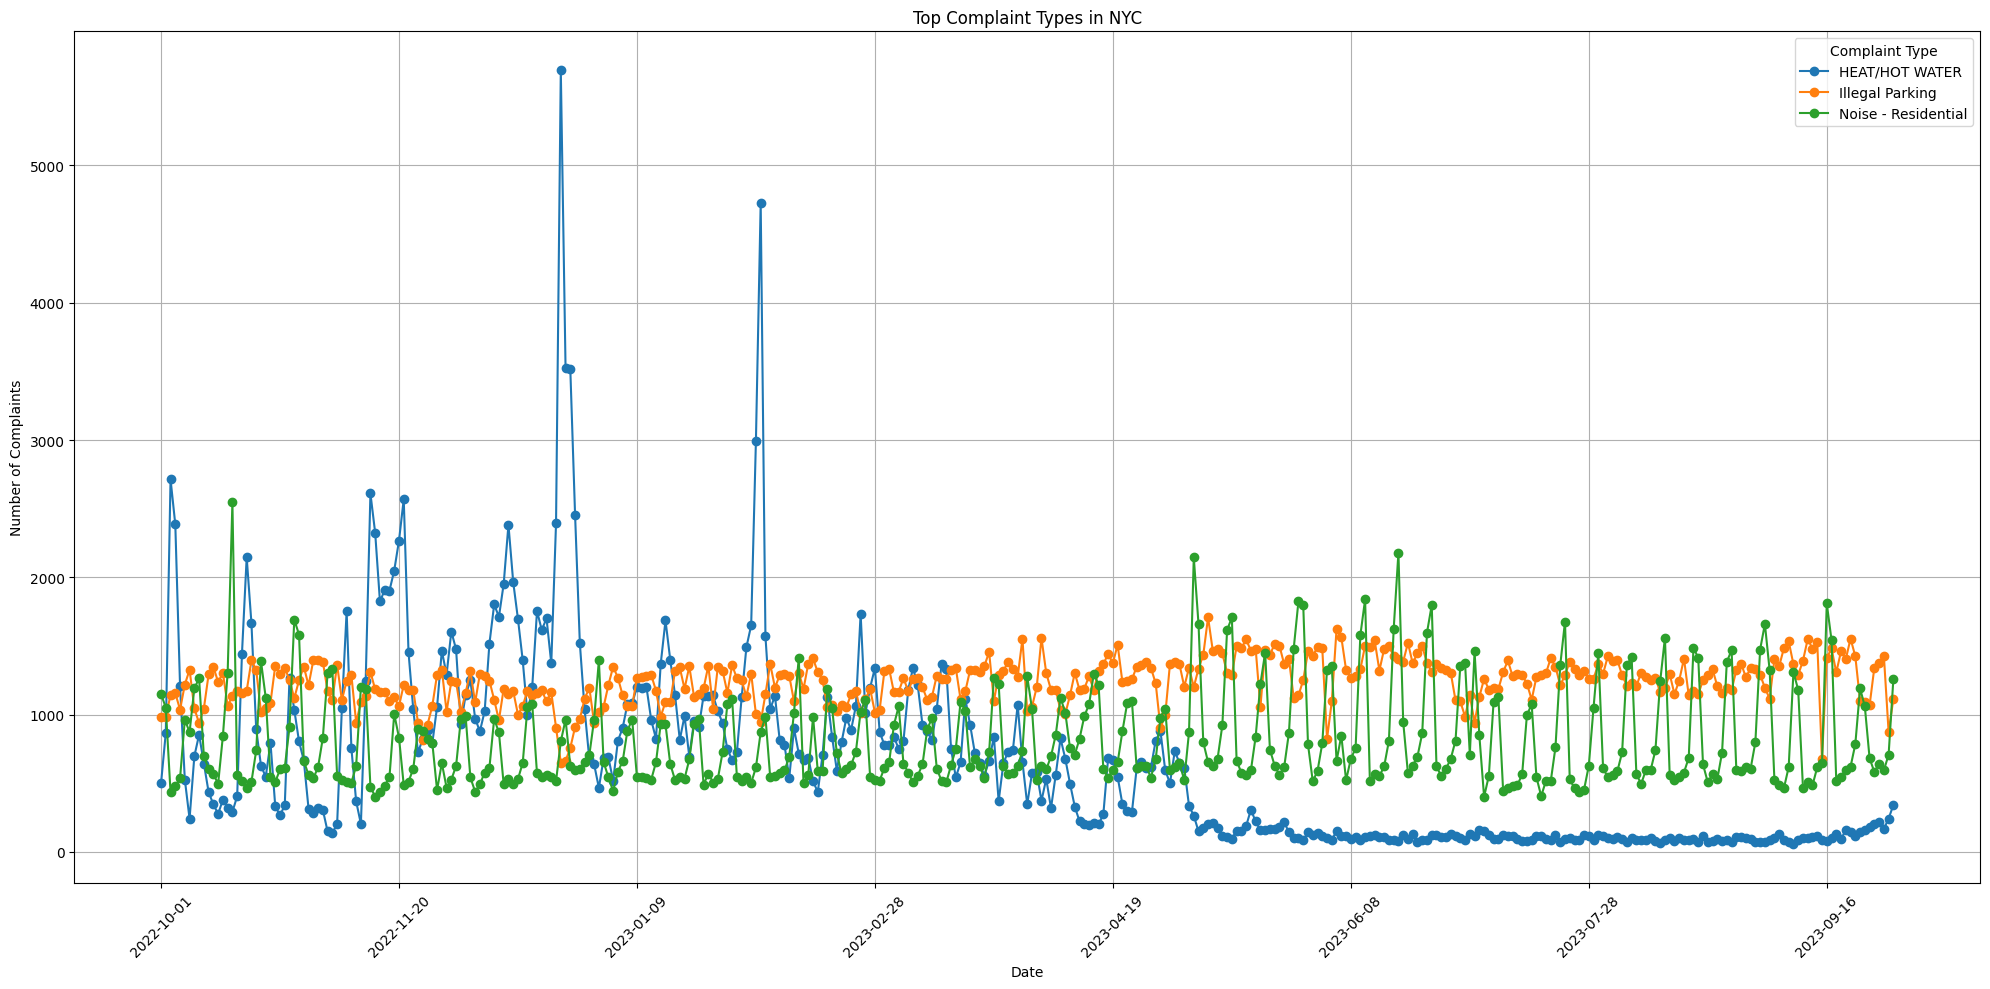

In [85]:
dataframe = get_data_for_top_complaints(start_date="2022-10-01", end_date="2023-09-30", top_n=3)
visualize_data_for_top_complaints(dataframe)

### 1.1. Interactive Visualization 1.1
### What can I expect to put up with in NYC with different number top complaints to show with switchbar.

In [86]:
def visualize_top_complaints(start_date, end_date, top_n=3):
    """
    Visualize the top complaint types for a given timeframe in NYC using SQL queries.

    Parameters:
    start_date (str): Start date in the format 'YYYY-MM-DD'.
    end_date (str): End date in the format 'YYYY-MM-DD'.
    top_n (int, optional): Number of top complaint types to visualize. Defaults to 3.
    """
    # SQL query to get top 'n' complaint types
    top_complaint_types_sql = f"""
    SELECT complaint_type, COUNT(*) as count
    FROM complaint
    WHERE date >= '{start_date}' AND date <= '{end_date}'
    GROUP BY complaint_type
    ORDER BY count DESC
    LIMIT {top_n};
    """
    top_complaint_types_df = pd.read_sql_query(top_complaint_types_sql, engine)
    top_complaints = top_complaint_types_df['complaint_type'].tolist()

    # SQL query to get the number of complaints per day for the top 'n' complaint types
    complaints_per_day_sql = f"""
    SELECT date, complaint_type, COUNT(*) as count
    FROM complaint
    WHERE date >= '{start_date}' AND date <= '{end_date}'
    AND complaint_type IN %(complaint_types)s
    GROUP BY date, complaint_type
    ORDER BY date;
    """
    complaints_per_day_df = pd.read_sql_query(
        complaints_per_day_sql,
        engine,
        params={'complaint_types': tuple(top_complaints)}
    ).pivot(index='date', columns='complaint_type', values='count')

    # Plot the data
    complaints_per_day_df.plot(kind='line', figsize=(14, 7), marker='o')
    plt.title(f'Top {top_n} Complaint Types in NYC Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Complaints')
    plt.legend(title='Complaint Type')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [87]:
def interactive_top_complaints(top_n):
    """
    Displays an interactive visualization of the top N complaint types over a fixed date range.

    This function is designed to be used with an IPython interactive widget. It calls the 
    `visualize_top_complaints` function with a fixed start and end date and a variable `top_n`, 
    which represents the number of top complaints to visualize. The visualization pertains to the 
    year 2021.

    The interactive component is enabled via an integer slider that allows the user to select the 
    number of top complaint types to display. The slider is created and linked to this function 
    outside its scope using the `interact` method from IPython.

    Parameters:
    - top_n (int): The number of top complaint types to display in the visualization.

    Requires:
    - The `visualize_top_complaints` function must be defined and should accept three arguments:
      the start date, the end date, and the number of top complaints to visualize.
    - The IPython.display.interact function or its equivalent from other interactive widget libraries.
    - The IntSlider widget or its equivalent for integer selection.

    Note: This function does not return a value but instead causes a side effect of displaying 
    an interactive visualization within an IPython environment, such as Jupyter Notebook or JupyterLab.

    Example:
    # Create a slider widget for top_n
    top_n_slider = IntSlider(min=1, max=10, value=3, description='Top N Complaints')

    # Display the interactive plot
    interact(interactive_top_complaints, top_n=top_n_slider)
    # This will display the interactive plot with a slider to select the top N complaint types.
    """
    visualize_top_complaints('2021-01-01', '2021-12-31', top_n)
# Create a slider widget for top_n
top_n_slider = IntSlider(min=1, max=10, value=3, description='Top N Complaints')

# Display the interactive plot
interact(interactive_top_complaints, top_n=top_n_slider)

interactive(children=(IntSlider(value=3, description='Top N Complaints', max=10, min=1), Output()), _dom_class…

<function __main__.interactive_top_complaints(top_n)>

In [ ]:
def interactive_top_complaints(top_n):
    """
    Displays an interactive visualization of the top N complaint types over a fixed date range.

    This function is designed to be used with an IPython interactive widget. It calls the 
    `visualize_top_complaints` function with a fixed start and end date and a variable `top_n`, 
    which represents the number of top complaints to visualize. The visualization pertains to the 
    year 2021.

    The interactive component is enabled via an integer slider that allows the user to select the 
    number of top complaint types to display. The slider is created and linked to this function 
    outside its scope using the `interact` method from IPython.

    Parameters:
    - top_n (int): The number of top complaint types to display in the visualization.

    Requires:
    - The `visualize_top_complaints` function must be defined and should accept three arguments:
      the start date, the end date, and the number of top complaints to visualize.
    - The IPython.display.interact function or its equivalent from other interactive widget libraries.
    - The IntSlider widget or its equivalent for integer selection.

    Note: This function does not return a value but instead causes a side effect of displaying 
    an interactive visualization within an IPython environment, such as Jupyter Notebook or JupyterLab.

    Example:
    # Create a slider widget for top_n
    top_n_slider = IntSlider(min=1, max=10, value=3, description='Top N Complaints')

    # Display the interactive plot
    interact(interactive_top_complaints, top_n=top_n_slider)
    # This will display the interactive plot with a slider to select the top N complaint types.
    """
    visualize_top_complaints('2021-01-01', '2021-12-31', top_n)
# Create a slider widget for top_n
top_n_slider = IntSlider(min=1, max=10, value=3, description='Top N Complaints')

# Display the interactive plot
interact(interactive_top_complaints, top_n=top_n_slider)

### 2. Visualization 2
### What are the most common in the immediate area?
Create a visualization that shows the number of complaints by complaint type for the top 10 complaints in zip code 10027 for October 1st, 2018 to September 30th, 2023 (inclusive).

In [88]:
def get_data_for_top_complaints_zip(zipcode, start_date, end_date, top_n):
    """
    Queries the database for the top 'n' complaint types for a specific zipcode within a specified date range.

    Args:
        - zipcode (int): The zipcode to filter the complaints by.
        - start_date (str): The start date of the period to consider.
        - end_date (str): The end date of the period to consider.
        - top_n (int): The number of top complaint types to retrieve.

    Returns:
        DataFrame: A pandas DataFrame containing the top 'n' complaint types and their counts for the specified zipcode and date range.
    """
    # SQL query to get the top 'n' complaint types for a specific zipcode within the date range
    complaints_by_type_sql = f"""
    SELECT complaint_type, COUNT(*) as count
    FROM complaint
    WHERE date BETWEEN %(start_date)s AND %(end_date)s
    AND zipcode = %(zipcode)s
    GROUP BY complaint_type
    ORDER BY count DESC
    LIMIT %(top_n)s;
    """

    complaints_by_type_df = pd.read_sql_query(
        complaints_by_type_sql,
        engine,
        params={'zipcode': zipcode, 'start_date': start_date, 'end_date': end_date, 'top_n': top_n}
    )

    return complaints_by_type_df.set_index('complaint_type')

In [89]:
def visualize_data_for_top_complaints_zip(dataframe, zipcode, start_date, end_date, top_n):
    """
    Plots the data from the dataframe as a bar chart, showing the top 'n' complaint types for a given zipcode and date range.

    Args:
        - dataframe (DataFrame): DataFrame containing the data to plot.
        - zipcode (int): The zipcode for which the data is plotted.
        - start_date (str): The start date of the period considered in the plot.
        - end_date (str): The end date of the period considered in the plot.
        - top_n (int): The number of top complaint types shown in the plot.
    """
    dataframe.plot(kind='bar', figsize=(12, 6), color='lightblue')
    plt.title(f'Top {top_n} Complaint Types in Zip Code {zipcode} ({start_date} - {end_date})')
    plt.xlabel('Complaint Type')
    plt.ylabel('Number of Complaints')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

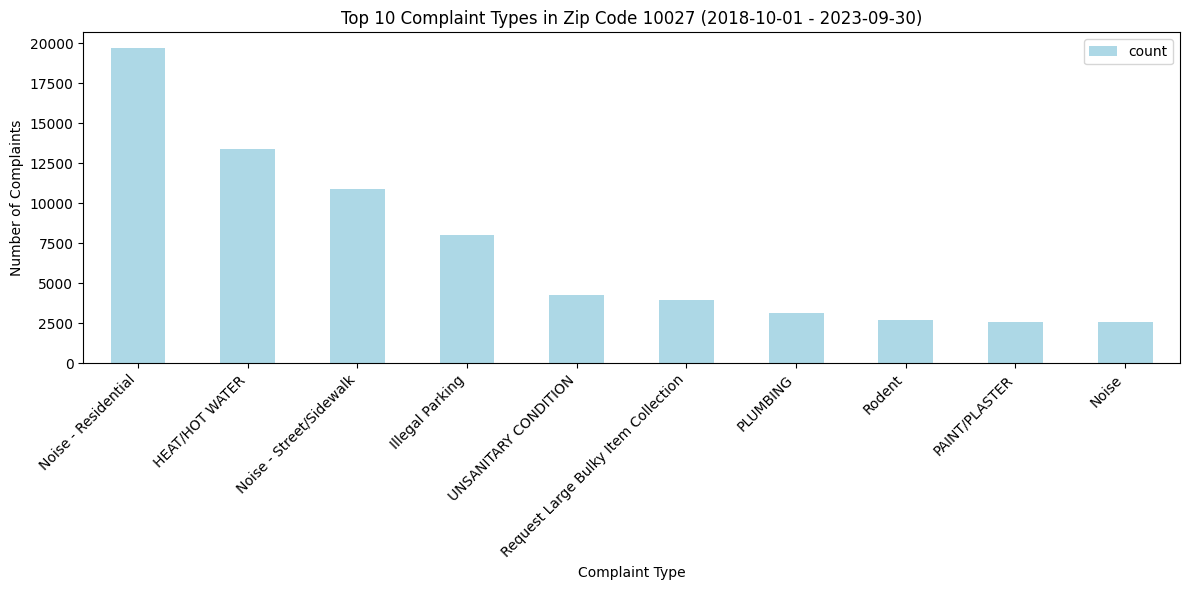

In [90]:
complaints_data = get_data_for_top_complaints_zip(zipcode = 10027, start_date = '2018-10-01', end_date = '2023-09-30', top_n=10)
visualize_data_for_top_complaints_zip(complaints_data, zipcode = 10027, start_date = '2018-10-01', end_date = '2023-09-30', top_n=10)

### 2.1 Animation Data Visualization

In [91]:
def get_data_for_top_complaints_zip(zipcode, start_date, end_date, top_n):
    """
    Retrieves and returns a DataFrame with the count of complaint types for a given zipcode 
    and date range, grouped by month and year.
    
    This function executes a SQL query that selects the year and month from the complaint date, 
    the type of complaint, and the total count of each complaint type. The results are filtered 
    by a specific zipcode and date range, grouped by the month-year and complaint type, and then 
    ordered by the month-year and count in descending order to get the most common complaints at the top.
    
    Parameters:
    - zipcode (int or str): The zipcode to filter the complaints.
    - start_date (str): The start date for the date range filter, in 'YYYY-MM-DD' format.
    - end_date (str): The end date for the date range filter, in 'YYYY-MM-DD' format.
    - top_n (int): The number of top complaints to return. (Currently not used)
    
    Returns:
    - DataFrame: A Pandas DataFrame with the month-year, complaint type, and count of complaints,
                 sorted by month-year and count in descending order.
    
    Requires:
    - A valid SQL connection 'engine' must be established before calling this function.
    
    Example:
    >>> get_data_for_top_complaints_zip(10001, '2021-01-01', '2021-06-30', 5)
    # Returns a DataFrame with complaint counts for zipcode 10001 from January to June 2021.
    """
    complaints_by_time_sql = f"""
    SELECT to_char(date::date, 'YYYY-MM') as month_year, complaint_type, COUNT(*) as count
    FROM complaint
    WHERE date BETWEEN '{start_date}' AND '{end_date}'
    AND zipcode = {zipcode}
    GROUP BY month_year, complaint_type
    ORDER BY month_year, count DESC;
    """

    return pd.read_sql_query(complaints_by_time_sql, engine)

In [92]:
def animate_top_complaints(zipcode, start_date, end_date, top_n):
    """
    Creates and returns an animation of the top N complaint types for a given zipcode and date range.

    The function first retrieves data for complaints using `get_data_for_top_complaints_zip` function. 
    It then creates a pivot table to reformat the data with 'month_year' as the index, the 
    'complaint_type' as the columns, and the 'count' of complaints as the values, filling any 
    missing values with 0. It identifies the top N complaint types based on the total count across 
    all months. The pivot table is then filtered to only include these top complaint types.

    An animation is created where each frame corresponds to a different month, showing a horizontal 
    bar chart of the counts of the top complaint types for that month. The animation progresses 
    through the months in the given date range.

    Parameters:
    - zipcode (int or str): The zipcode to filter the complaints.
    - start_date (str): The start date for the date range filter, in 'YYYY-MM-DD' format.
    - end_date (str): The end date for the date range filter, in 'YYYY-MM-DD' format.
    - top_n (int): The number of top complaint types to display in the animation.

    Returns:
    - FuncAnimation: A matplotlib.animation.FuncAnimation object that can be displayed or saved.
    
    Requires:
    - The `matplotlib.pyplot` module must be imported as `plt`.
    - The `matplotlib.animation` module must be imported.
    - The `get_data_for_top_complaints_zip` function must be defined.
    - A valid SQL connection 'engine' must be established before calling this function.
    """
    df = get_data_for_top_complaints_zip(zipcode, start_date, end_date, top_n)
    df_pivot = df.pivot_table(index='month_year', columns='complaint_type', values='count', fill_value=0)
    top_complaints = df_pivot.sum().sort_values(ascending=False).head(top_n).index
    df_pivot = df_pivot[top_complaints]

    fig, ax = plt.subplots(figsize=(12, 6))

    def animate(i):
        ax.clear()
        df_pivot.iloc[i].sort_values().plot(kind='barh', ax=ax, color='lightblue')
        ax.set_title(f'Top {top_n} Complaint Types in Zip Code {zipcode} for {df_pivot.index[i]}')
        ax.set_xlabel('Number of Complaints')
        ax.set_ylabel('Complaint Type')

    ani = animation.FuncAnimation(fig, animate, frames=len(df_pivot), repeat=False)
    plt.close()
    return ani


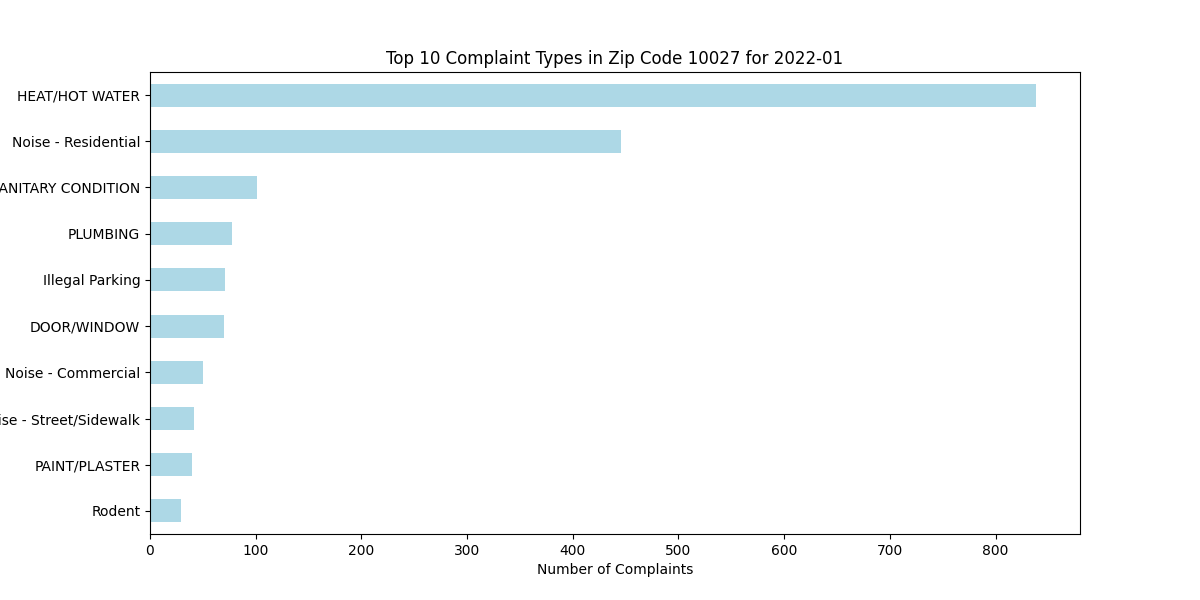

In [93]:
# For purpose, we only use shorter timeframe to display the optimization
ani = animate_top_complaints(zipcode=10027, 
                             start_date='2022-01-01', end_date='2023-09-30', 
                             top_n = 10)
ani.save("data/dv2_complaints_animation.gif", writer='ffmpeg',fps=3)
display(IPImage(filename='data/dv2_complaints_animation.gif'))

### 3. Visualization 3
### Is there any correlation between rent, trees, and complaints at all?
Between January 1st, 2015 and September 30th, 2023 (inclusive), create a visualization using 2 subplots that share the x-axis where one subplot shows rent compared to the number of trees by zip code, and the other subplot shows rent compared to the number of complaints by zip code.

In [94]:
def get_data_for_rent_trees_complaints_correlation(start_date, end_date):
    """
    Queries the database for aggregated data on rent, trees, and complaints by zipcode for the specified date range.

    Args:
    - start_date (str): The start date of the period to consider in 'YYYY-MM-DD' format.
    - end_date (str): The end date of the period to consider in 'YYYY-MM-DD' format.

    Returns:
    - DataFrame: A pandas DataFrame with columns for average rent, tree count, and complaint count per zipcode.
    """
    # SQL queries to get the required data
    rent_sql = f"""
    SELECT zipcode, AVG(rent) as average_rent
    FROM zillow
    WHERE date BETWEEN %(start_date)s AND %(end_date)s
    GROUP BY zipcode;
    """

    tree_sql = f"""
    SELECT zipcode, COUNT(*) as tree_count
    FROM tree
    WHERE date BETWEEN %(start_date)s AND %(end_date)s
    GROUP BY zipcode;
    """

    complaint_sql = f"""
    SELECT zipcode, COUNT(*) as complaint_count
    FROM complaint
    WHERE date BETWEEN %(start_date)s AND %(end_date)s
    GROUP BY zipcode;
    """

    # Execute the queries and store in DataFrames
    rent_df = pd.read_sql_query(rent_sql, engine, params={'start_date': start_date, 'end_date': end_date})
    tree_df = pd.read_sql_query(tree_sql, engine, params={'start_date': start_date, 'end_date': end_date})
    complaint_df = pd.read_sql_query(complaint_sql, engine, params={'start_date': start_date, 'end_date': end_date})

    # Merge the DataFrames on the zipcode
    merged_data = rent_df.merge(tree_df, on='zipcode').merge(complaint_df, on='zipcode')
    return merged_data

In [95]:
def visualize_data_for_rent_trees_complaints_correlation(data, start_date, end_date):
    """
    Plots the relationship between average rent and number of trees, and average rent and number of complaints, by zipcode.

    Args:
    - data (DataFrame): The pandas DataFrame containing the aggregated data for rent, trees, and complaints.
    - start_date (str): The start date of the data in 'YYYY-MM-DD' format.
    - end_date (str): The end date of the data in 'YYYY-MM-DD' format.

    Returns:
    None - Displays the plots.
    """
    # Create a figure and a set of subplots with shared x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

    # First subplot: Rent vs. Trees
    ax1.scatter(data['average_rent'], data['tree_count'], color='green')
    ax1.set_ylabel('Number of Trees')
    ax1.set_title(f'Rent vs. Number of Trees by Zip Code (from {start_date} to {end_date})')

    # Second subplot: Rent vs. Complaints
    ax2.scatter(data['average_rent'], data['complaint_count'], color='red')
    ax2.set_ylabel('Number of Complaints')
    ax2.set_xlabel('Average Rent')
    ax2.set_title(f'Rent vs. Number of Complaints by Zip Code (from {start_date} to {end_date})')

    # Display the plot
    plt.tight_layout()
    plt.show()

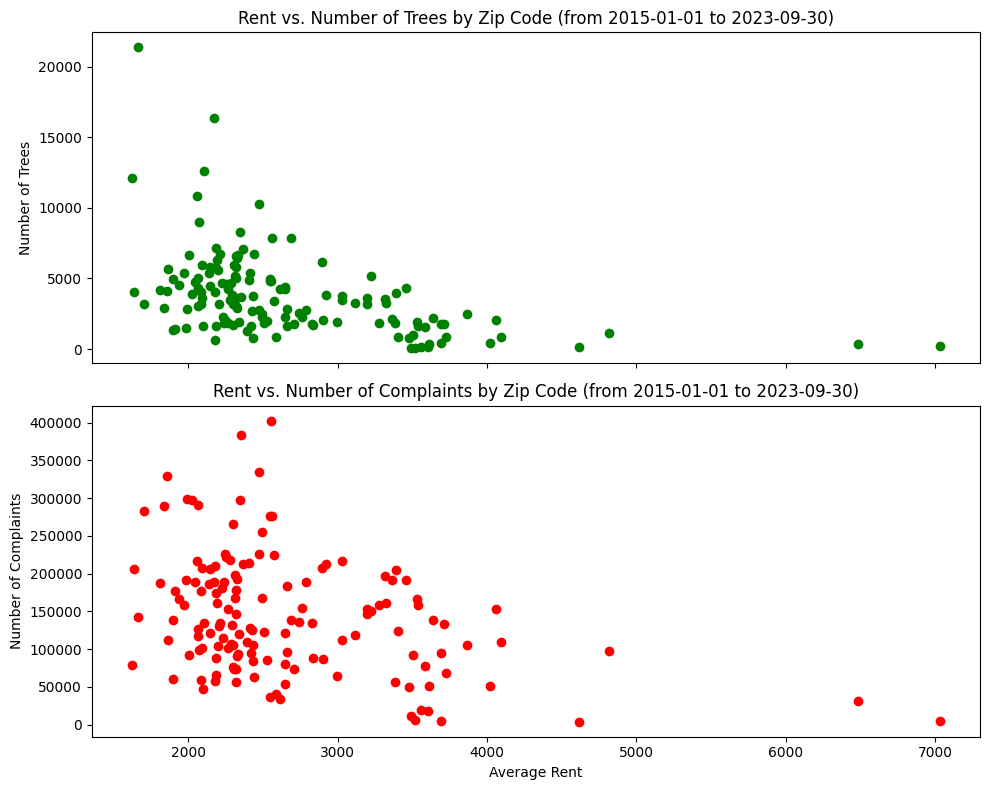

In [96]:
data = get_data_for_rent_trees_complaints_correlation(start_date='2015-01-01', end_date='2023-09-30')
visualize_data_for_rent_trees_complaints_correlation(data, start_date='2015-01-01', end_date='2023-09-30')

### 4. Visualization 4
### If I can afford more in rent, will there be fewer issues & complaints?
Create a boxplot, where the x-axis is average rent in September 2023, separated into $1000 bins (i.e. $0-1000, $1001-2000, etc), and the y-axis is the number of 311 complaints observed in each zip code between October 1, 2022 (inclusive) to September 30, 2023 (inclusive).

In [ ]:
def get_data_rent_complaints_for_boxplot(rent_date, complaint_start_date, complaint_end_date):
    """
    Fetches and aggregates rent and complaints data from a PostgreSQL database for boxplot visualization.

    This function retrieves the average rent for a specified date and counts the number of complaints
    in a given date range, both grouped by zipcode. It then merges these datasets and prepares bins
    for the average rent, facilitating the creation of a boxplot visualization.

    Args:
    - rent_date (str): The specific date for which to fetch average rent data in 'YYYY-MM-DD' format.
    - complaint_start_date (str): The start date of the period for counting complaints in 'YYYY-MM-DD' format.
    - complaint_end_date (str): The end date of the period for counting complaints in 'YYYY-MM-DD' format.

    Returns:
    - DataFrame: A pandas DataFrame with merged rent and complaints data, including rent bins for visualization.
    """

    rent_sql = """
    SELECT zipcode, AVG(rent) as average_rent
    FROM zillow
    WHERE date = %(rent_date)s
    GROUP BY zipcode;
    """

    complaints_sql = """
    SELECT zipcode, COUNT(*) as complaints_count
    FROM complaint
    WHERE date >= %(complaint_start_date)s AND date <= %(complaint_end_date)s
    GROUP BY zipcode;
    """

    rent_data = pd.read_sql_query(rent_sql, engine, params={'rent_date': rent_date})
    complaints_data = pd.read_sql_query(complaints_sql, engine, params={'complaint_start_date': complaint_start_date, 'complaint_end_date': complaint_end_date})

    # Merge the DataFrames on the zipcode
    data_for_boxplot = pd.merge(rent_data, complaints_data, on='zipcode', how='inner')

    # Ensure bins are consistent with the original method
    max_rent = data_for_boxplot['average_rent'].max()
    # Set the range to cover up to the maximum rent plus a bit more
    bins = list(range(0, int(max_rent) + 1000, 1000))
    data_for_boxplot['rent_bin'] = pd.cut(data_for_boxplot['average_rent'], bins=bins, right=False)

    return data_for_boxplot

In [ ]:
def visualize_data_rent_complaints_for_boxplot(data_for_boxplot):
    """
    Visualizes the relationship between average rent and the number of 311 complaints using a boxplot.

    This function creates a boxplot to display the distribution of 311 complaints across different rent bins. It takes a DataFrame (data_for_boxplot) that contains at least two columns: 'rent_bin' representing categories of average rent, and 'complaints_count' representing the number of 311 complaints associated with each rent bin.

    The function sets the plot style to 'ggplot' for better aesthetics. The boxplot is plotted with 'rent_bin' on the x-axis and 'complaints_count' on the y-axis. The title and axis labels are set to provide context about the data, specifically indicating that the plot shows data for September 2023, and rent is categorized in $1000 bins.

    The x-ticks are rotated by 45 degrees for better readability. The plot layout is adjusted for tight fitting of elements, and the plot is then displayed.

    Parameters:
    data_for_boxplot (DataFrame): A DataFrame with columns 'rent_bin' and 'complaints_count'.

    Returns:
    None: This function does not return anything but displays a matplotlib plot.
    """
    plt.style.use('ggplot')
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='rent_bin', y='complaints_count', data=data_for_boxplot)
    plt.title('Number of 311 Complaints vs. Average Rent (Sep 2023)')
    plt.xlabel('Average Rent in September 2023 ($1000 bins)')
    plt.ylabel('Number of 311 Complaints')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
data_for_boxplot = get_data_rent_complaints_for_boxplot(rent_date='2023-09-30',complaint_start_date='2022-10-01', complaint_end_date='2023-09-30')
visualize_data_rent_complaints_for_boxplot(data_for_boxplot)